## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 40000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 40000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})



def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'gfci', dfs = df, testId = 'bdeu', scoreId = 'bdeu', dataType = 'discrete',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            parents.add(i[-1])
    return parents

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()



#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
variances = [1, 1.5, 2, 2.5, 3, 3.5, 4]

#the number of times to sample 
times = 4

## the size of the test set
nb_test = 2000

val_split = 0.2
verbosity = 1

def run_models(models, model_names):
    violations = np.zeros(len(models))
    violation_mean = np.zeros((len(models), times))
    mean = np.zeros((len(models), times))

    fold = 0
    
    metrics_dicts = []
    causal_dicts = []
    for m in models:
        metrics_dicts.append(defaultdict(list))
        causal_dicts.append(defaultdict(list))

    

    df = gen_data()
    X = df[['a', 'b', 'c', 'd', 'e', 'f']].values
    y = df['g'].values

    for idx, mod in enumerate(models):
        #clear session
        keras.backend.clear_session() 

        #get model according to specification
        model = get_model(mod, [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint('temp', verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_split = val_split, callbacks = callbacks, batch_size = 32, verbose = verbosity)

        #load best model according to loss
        model = load_model('temp')

        
        for t in range(times):
            print("Times = ", t)
            df_test = gen_data(SIZE = nb_test)
            x_test = df_test[['a', 'b', 'c', 'd', 'e', 'f']].values
            y_test = df_test['g'].values
            
            #original_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            #original_targets = pd.DataFrame(y_test, columns = ['g'])
            #original_df = original_df.join(original_targets)
            test_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            test_targets = pd.DataFrame(model.predict(x_test), columns = ['g'])
            test_df = test_df.join(test_targets)
            mean[idx][t] = mean_squared_error(y_test, model.predict(x_test))  
            print(mean_squared_error(y))
            #print(len(y_test), len(df_test), len(test_df))
            setA = get_MB(get_CG(df_test, tetrad), 'g', pc)
            setB = get_MB(get_CG(test_df, tetrad), 'g', pc)

            if setA != {'f'}:
                print("Error in SETA markov blanket")
                setA = {'f'}

            violation_mean[idx][t] = len(setA.difference(setB)) + len(setB.difference(setA))
            if setA != setB:
                print("Violation:", model_names[idx], setA , setB)
                violations[idx] += 1


        # ok at this point we need to check the model on various variances and means
        for m in means:
            for v in variances:
                perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
                y_test2 = perturbed_df['g']
                x_test2 = perturbed_df[['a', 'b', 'c', 'd', 'e', 'f']]
                y_pred2 = model.predict(x_test2)
                metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

                test_df2 = pd.DataFrame(x_test2, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
                test_targets2 = pd.DataFrame(model.predict(x_test2), columns = ['g'])
                test_df2 = test_df2.join(test_targets2)

                setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
                if setA != {'f'}:
                    print("Error in SETA markov blanket")
                    setA = {'f'}
                setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

                if setA != setC:
                    causal_dicts[idx][str(m) + '_' + str(v)].append(1)
                else:
                    causal_dicts[idx][str(m) + '_' + str(v)].append(0)
                    

    
    print("Violations = ", violations)
    
    metric = []
    metric_err = []
    viol = []
    viol_err = []
    
    #normalize the violations for prettier graphing.
    #also violations are always positive, so just divide by max.
    violation_mean = violation_mean / np.max(violation_mean)
    
    for i in range(len(violations)):
        print("Model_name = ", model_names[i], "Violations = ", violations[i])
        print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
        print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
        print("mean = ", mean[i])
        metric.append(np.mean(mean[i]))
        metric_err.append(np.std(mean[i]))
        viol.append(np.mean(violation_mean[i]))
        
        viol_err.append(np.std(violation_mean[i]))
    print(np.array(metric), 
             np.array(metric_err), 
             np.array(viol), 
             np.array(viol_err))    
    
    bar_plot(model_names, 
             np.array(metric), 
             np.array(metric_err), 
             np.array(viol), 
             np.array(viol_err))
    return metrics_dicts, causal_dicts



'''
models = [LogisticRegression(), 
          Perceptron(),  
          DecisionTreeClassifier(),
          LinearSVC(),
          GaussianNB(),
          LinearDiscriminantAnalysis(),
          RandomForestClassifier(),
          ExtraTreesClassifier(),
          AdaBoostClassifier(),
          BaggingClassifier(),
          GradientBoostingClassifier(),
          MLPClassifier()
         ]
model_names = ['LogisticRegression()', 
          'Perceptron()',  
          'DecisionTreeClassifier()',
          'LinearSVC()',
          'GaussianNB()',
          'LinearDiscriminantAnalysis()',
          'RandomForestClassifier()',
          'ExtraTreesClassifier()', 
          'AdaBoostClassifier()',
          'BaggingClassifier()',
          'GradientBoostingClassifier()',
          'MLPClassifier()'
         ]

'''

models = [#[8,8,4],
          #[16,16,8],
          #[32,32,16],
          #[64,64,32],
          [128, 128, 64],
          [256, 256, 128],
          [512, 512, 256],
          [1024, 1024, 512],
          [2048, 2048, 1024],
         ]
model_names = [#'m1', 
               #'m2',
               #'m3',
               #'m4', 
               'm5',
               'm6',
               'm7', 
               'm8',
               'm9'
              ]

metrics, violations = run_models(models,model_names)

Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 4s 123us/step - loss: 1.3409 - mean_squared_error: 1.3409 - val_loss: 1.1893 - val_mean_squared_error: 1.1893

Epoch 00001: val_loss improved from inf to 1.18926, saving model to temp
Epoch 2/20
32000/32000 [==============================] - 4s 114us/step - loss: 1.1786 - mean_squared_error: 1.1786 - val_loss: 1.1523 - val_mean_squared_error: 1.1523

Epoch 00002: val_loss improved from 1.18926 to 1.15232, saving model to temp
Epoch 3/20
32000/32000 [==============================] - 4s 111us/step - loss: 1.1597 - mean_squared_error: 1.1597 - val_loss: 1.1533 - val_mean_squared_error: 1.1533

Epoch 00003: val_loss did not improve from 1.15232
Epoch 4/20
32000/32000 [==============================] - 4s 110us/step - loss: 1.1557 - mean_squared_error: 1.1557 - val_loss: 1.1117 - val_mean_squared_error: 1.1117

Epoch 00004: val_loss improved from 1.15232 to 1.11166, saving model to te

KeyboardInterrupt: 

m5


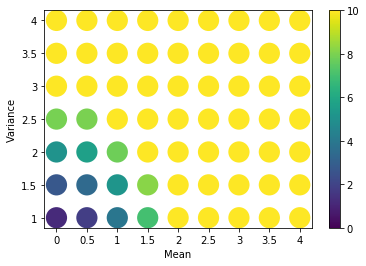

m6


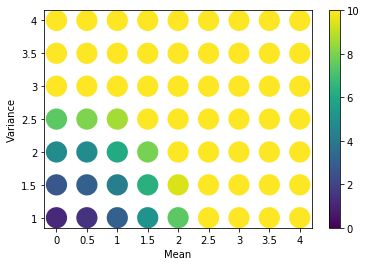

m7


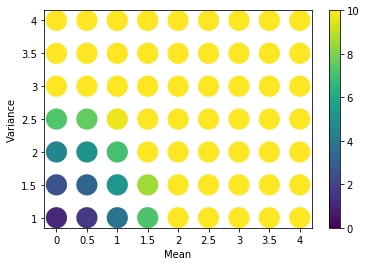

m8


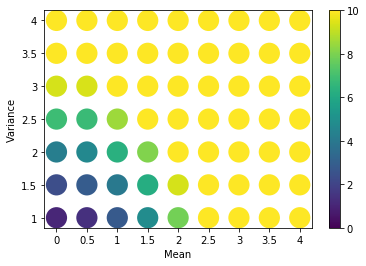

m9


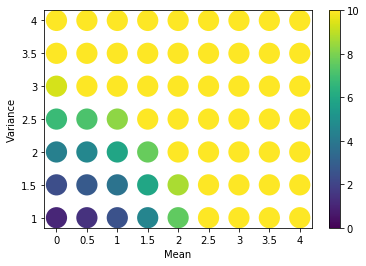

m5
Causal assurance


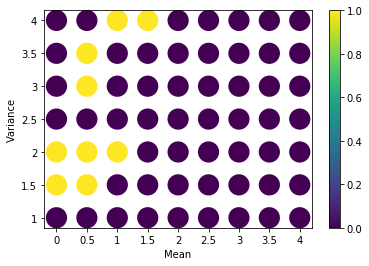

m6
Causal assurance


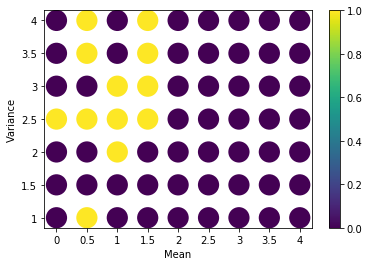

m7
Causal assurance


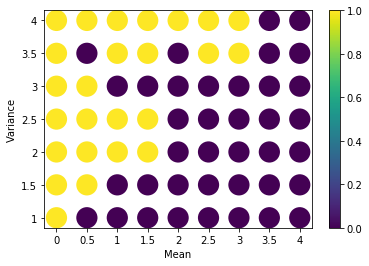

m8
Causal assurance


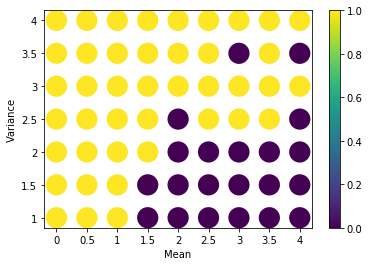

m9
Causal assurance


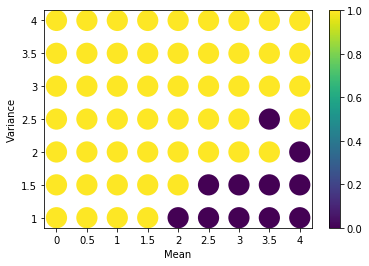

In [38]:
def heat_plot(x,y,z, clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel('Mean')
    ax.set_ylabel('Variance')
    plt.colorbar(cax)
    plt.show()

for idx, m in enumerate(models):
    print(model_names[idx])
    x = []
    y = []
    z = []
    
    
    
    for k, v in metrics[idx].items():
        x.append(k.split('_')[0])
        y.append(k.split('_')[-1])
        z.append(np.mean(v))
        
    heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
for idx, m in enumerate(models):
    print(model_names[idx])      
    x = []
    y = []
    z = []
    for k, v in violations[idx].items():
        x.append(k.split('_')[0])
        y.append(k.split('_')[-1])
        z.append(np.sum(v) / len(v))
    print("Causal assurance")
    heat_plot(x,y,z, clim_low = 0, clim_high = 1) 